# Femme au volant, mort au tournant ?

## Introduction

Question bien fâcheuse que celle de la mortalité des véhicules à roues. Plus particulièrement, des facteurs influençant ces risques. Si notre enfance a été bercée de slogans douteux concernant la conduite, à l'instar du fameux "Femme au volant, mort au tournant", est-il statistiquement plus probable qu'une femme cause un accident mortel qu'un homme ? 

Au cours de ce projet, nous cherchons à analyser si, à caractéristiques comparables, le genre du conducteur est associé à une différence de gravité dans les accidents de la route en France en 2024. 
Nous reprenons ici la définition d'accident de la route de l'Arrêté du 27 mars 2007 relatif aux conditions d’élaboration des statistiques relatives aux accidents corporels de la circulation : "Un accident corporel de la circulation routière
- provoque la mort ou la blessure d'une ou plusieurs personnes,
- survient sur une voie ouverte à la circulation publique (code de la route),
- en excluant les actes volontaires (homicides volontaires, suicides...) et les catastrophes naturelles.
- implique au moins un véhicule roulant ou se déplaçant."

Nous nous basons sur les données collectées par le *Ministère de l'Intérieur* sur l'année 2024, disponibles sur le site data.gouv à *[l'adresse suivante](https://www.data.gouv.fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024)*. Plus précisément, nous avons choisi les fichiers concernant respectivement les caractéristiques spatio-temporelles des accidents, et les caractéristiques des conducteurs comme l'*âge* et le *sexe*. Comme nous le détaillerons plus loin, ces données s'avèrent propres, et nécessitent peu de travail de nettoyage.

Nous amorcerons notre analyse par des visualisation, qui servira une analyse descriptive, et où nous pourrons constater quelques faits intéressants sur les accidents de la route. Ensuite, nous construirons et comparerons différents outils de modélisation de la gravité d'un potentiel accident. Nous commencerons par plusieurs régressions linéaires et logistiques, et une random forest. Notre objectif final est de développer un réseau neuronal permettant de prédire la mortalité d'une situation en fonction de données connues par le conducteur.


## Réflexion sur la collecte des données

Les données sont collectées par les diverses forces de l'ordre (gendarmerie nationale, sécurité publique, Préfecture de police de Paris, Compagnies Républicaines de Sécurité). Selon l'article R 231-1 du code de la route, "Tout usager impliqué dans un accident corporel de la circulation routière survenu sur le réseau routier ouvert à la circulation publique et impliquant au moins un véhicule doit en avertir les forces de l’ordre".  Lorsqu'elles sont mises au courant d'un accident de la route, ces dernières sont dans l'obligation de remplir un BAAC (Bulletin d'Analyse des Accidents de la Circulation), BAAC qui sont répertoriés dans la base de donnée que nous utilisons ici.
Le dataset n'est donc représentatif que dans la mesure où les individus impliqués dans des accidents de la circulation sur le territoire français respectent la loi, ce qui est une limite non-négligeable. On peut imaginer de nombreux cas où les personnes accidentées ne déclarent pas l'incident aux forces de l'ordre. Assez simplement, même si, pour citer un autre adage, "nul n'est censé ignorer la loi", il n'est pas aberrant de penser qu'un individu qui sort d'un accident de la circulation d'où le véhicule, l'obstacle et sa personne sortent indemne, ne pense pas à le déclarer à la gendarmerie.

De plus, il y a dans ce dataset une sur-représentation des données récoltées en métropole (la récolte des données est gérée différemment outre-mer). Les résultats de nos analyses ne seront donc représentatifs que des accidents de la route en métropole française en 2024.

## Récupération, nettoyage et enrichissement de la base de données

On commence par importer les librairies et les données. Ces dernières sont mises à disposition par l'Observatoire national interministériel de la sécurité routière (ONISR). Elles ont été récupérées via le site data.gouv.fr.

In [1]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from matplotlib import pyplot as plt
from datetime import time, datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

import xgboost as xgb

2025-12-29 23:18:15.497707: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-29 23:18:15.498154: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-29 23:18:15.565304: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-29 23:18:16.901718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-poin

In [2]:
df_c = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115900/caract-2024.csv', encoding="utf-8", sep=';', engine='python')
df_u = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115506/usagers-2024.csv', encoding="utf-8", sep=';', engine='python')
df_l = pd.read_csv('https://static.data.gouv.fr/resources/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2024/20251021-115812/lieux-2024.csv', encoding="utf-8", sep=';', engine='python')

In [3]:
df_c.info()
df_c.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54402 entries, 0 to 54401
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  54402 non-null  int64 
 1   jour     54402 non-null  int64 
 2   mois     54402 non-null  int64 
 3   an       54402 non-null  int64 
 4   hrmn     54402 non-null  object
 5   lum      54402 non-null  int64 
 6   dep      54402 non-null  object
 7   com      54402 non-null  object
 8   agg      54402 non-null  int64 
 9   int      54402 non-null  int64 
 10  atm      54402 non-null  int64 
 11  col      54402 non-null  int64 
 12  adr      52092 non-null  object
 13  lat      54402 non-null  object
 14  long     54402 non-null  object
dtypes: int64(9), object(6)
memory usage: 6.2+ MB


,Num_Acc,jour,mois,an,hrmn,lum,dep,com,agg,int,atm,col,adr,lat,long
0,202400000001,25,3,2024,07:40,2,70,70285,1,1,5,1,D438,"47,56277000","6,75832000"
1,202400000002,20,3,2024,15:05,1,21,21054,2,3,7,6,HOTEL DIEU (RUE DE L'),"47,02109000","4,83755000"
2,202400000003,22,3,2024,19:30,2,15,15012,1,1,1,6,Allée des Tilleuls,"44,90238400","2,49641800"
3,202400000004,24,3,2024,17:50,1,14,14118,2,3,7,3,128 Rue d'Authie,"49,19166000","-0,39851000"
4,202400000005,25,3,2024,19:35,5,13,13106,1,3,2,5,BEDOULE (CHEMIN DE LA),"43,39000000","5,35000000"


In [4]:
df_u.info()
df_u.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125187 entries, 0 to 125186
Data columns (total 16 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      125187 non-null  int64  
 1   id_usager    125187 non-null  object 
 2   id_vehicule  125187 non-null  object 
 3   num_veh      125187 non-null  object 
 4   place        125187 non-null  int64  
 5   catu         125187 non-null  int64  
 6   grav         125187 non-null  int64  
 7   sexe         125187 non-null  int64  
 8   an_nais      122608 non-null  float64
 9   trajet       125187 non-null  int64  
 10  secu1        125187 non-null  int64  
 11  secu2        125187 non-null  int64  
 12  secu3        125187 non-null  int64  
 13  locp         125187 non-null  int64  
 14  actp         125187 non-null  object 
 15  etatp        125187 non-null  int64  
dtypes: float64(1), int64(11), object(4)
memory usage: 15.3+ MB


,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202400000001,203 988 581,155 781 758,A01,1,1,3,1,2003.0,2,1,-1,-1,-1,-1,-1
1,202400000001,203 988 582,155 781 759,B01,1,1,1,1,1997.0,4,1,-1,-1,-1,-1,-1
2,202400000002,203 988 579,155 781 757,A01,10,3,3,2,1927.0,5,0,-1,-1,3,3,1
3,202400000002,203 988 580,155 781 757,A01,1,1,1,1,1987.0,4,1,0,-1,3,3,1
4,202400000003,203 988 574,155 781 756,A01,2,2,4,2,2007.0,5,8,0,-1,-1,-1,-1


In [5]:
df_l.info()
df_l.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70248 entries, 0 to 70247
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  70248 non-null  int64 
 1   catr     70248 non-null  int64 
 2   voie     56917 non-null  object
 3   v1       70248 non-null  int64 
 4   v2       5916 non-null   object
 5   circ     70248 non-null  int64 
 6   nbv      70248 non-null  object
 7   vosp     70248 non-null  int64 
 8   prof     70248 non-null  int64 
 9   pr       70248 non-null  object
 10  pr1      70248 non-null  object
 11  plan     70248 non-null  int64 
 12  lartpc   33 non-null     object
 13  larrout  70248 non-null  object
 14  surf     70248 non-null  int64 
 15  infra    70248 non-null  int64 
 16  situ     70248 non-null  int64 
 17  vma      70248 non-null  int64 
dtypes: int64(11), object(7)
memory usage: 9.6+ MB


,Num_Acc,catr,voie,v1,v2,circ,nbv,vosp,prof,pr,pr1,plan,lartpc,larrout,surf,infra,situ,vma
0,202400000001,3,D438,0,NaN,2,2,0,1,1,260,2,NaN,7,1,0,1,90
1,202400000002,4,HOTEL DIEU (RUE DE L'),0,NaN,2,2,0,1,-1,-1,1,NaN,-1,9,0,1,30
2,202400000002,4,POTERNE (RUE),0,NaN,1,1,0,1,-1,-1,1,NaN,-1,9,0,1,30
3,202400000003,4,TILLEULS (ALLEE DES),0,NaN,2,2,0,1,-1,-1,1,NaN,-1,1,0,3,50
4,202400000004,4,AUTHIE (N° 106 PAIRS -115 IMPAIRS),0,NaN,2,4,0,1,-1,-1,1,NaN,-1,1,9,1,50


On remarque que, bien que les trois premières tables puissent être concaténées par le biais de la variable de jointure 'Num_Acc', elles ne contiennent pas la même quantité de données : chacune contient entre 54000 et 126000 lignes. En effet, chaque accident peut impliquer plusieurs véhicules, et chaque véhicule peut contenir plusieurs personnes. Etudions chaque table plus en détails :

### Table 'caract-2024' (df_c)

In [7]:
nb = df_c.isna().any(axis=1).sum()
print(nb)

2310


In [8]:
nb = df_c.drop(columns=['adr']).isna().any(axis=1).sum()
print(nb)

0


Les valeurs manquantes concernent la colonne 'adr' (adresse). Nous n'utiliserons pas cette variable dans notre analyse.
Nous supprimons d'ailleurs les colonnes inutilisées :

In [3]:
df_c.drop(columns=['int', 'col', 'adr', 'lat', 'long'], inplace=True)
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54402 entries, 0 to 54401
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Num_Acc  54402 non-null  int64 
 1   jour     54402 non-null  int64 
 2   mois     54402 non-null  int64 
 3   an       54402 non-null  int64 
 4   hrmn     54402 non-null  object
 5   lum      54402 non-null  int64 
 6   dep      54402 non-null  object
 7   com      54402 non-null  object
 8   agg      54402 non-null  int64 
 9   atm      54402 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 4.2+ MB


### Table 'usagers-2024' (df_u)

In [10]:
nb = df_u.isna().any(axis=1).sum()
print(nb)

2579


In [11]:
nb = df_u.drop(columns=['an_nais']).isna().any(axis=1).sum()
print(nb)

0


Ici, on remarque que les valeurs manquantes concernent la colonne 'an_nais' (année de naissance). Cette souhaitons utiliser cette variable dans notre analyse. Comme il ne manque que 25000 valeurs sur 125000 (soit deux pourcents environ), nous nous permetterons de supprimer les lignes concernées post-jointure.
Commençons par supprimer les variables relatives aux piétons impliqués, qui ne seront pas utilisées :

In [4]:
df_u.drop(columns=['locp', 'actp', 'etatp'], inplace=True)
df_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125187 entries, 0 to 125186
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Num_Acc      125187 non-null  int64  
 1   id_usager    125187 non-null  object 
 2   id_vehicule  125187 non-null  object 
 3   num_veh      125187 non-null  object 
 4   place        125187 non-null  int64  
 5   catu         125187 non-null  int64  
 6   grav         125187 non-null  int64  
 7   sexe         125187 non-null  int64  
 8   an_nais      122608 non-null  float64
 9   trajet       125187 non-null  int64  
 10  secu1        125187 non-null  int64  
 11  secu2        125187 non-null  int64  
 12  secu3        125187 non-null  int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 12.4+ MB


In [5]:
print(f'Total des accidentés indemnes : {(df_u['grav'] == 1).sum()}')
print(f'Total des accidentés tués : {(df_u['grav'] == 2).sum()}')
print(f'Total des accidentés blessés hospitalisés : {(df_u['grav'] == 3).sum()}')
print(f'Total des accidentés blessés légers : {(df_u['grav'] == 4).sum()}')
print(f'Total des accidentés : {(df_u['grav'] == 1).sum() + (df_u['grav'] == 2).sum() + (df_u['grav'] == 3).sum() + (df_u['grav'] == 4).sum()}')

Total des accidentés indemnes : 52920
Total des accidentés tués : 3432
Total des accidentés blessés hospitalisés : 19126
Total des accidentés blessés légers : 49709
Total des accidentés : 125187


Nous remarquons ici que la quantité de personnes tuées (3432, ce qui correspond aux chiffres officiels) est faible relativement à la quantité totale de personnes impliquées dans des accidents de la route en France en 2024, ce que toute notre bonne volonté méthodologique ne nous permettra pas de déplorer. Nous devrons néanmoins tenir compte de ce déséquilibre dans la suite de notre analyse.

### Table 'lieux-2024' (df_l)

Les colonnes 'v2' (indice alphanumérique de la route) et 'lartpc' (largeur du terre-plein central) contiennent de nombreuses cellules vides. Cependant, elles font partie des variables dont nous n'avons pas besoin ; nous les supprimons donc, parmi les autres variables inutilisées.

In [6]:
df_l.drop(columns=['voie', 'v1', 'v2', 'circ', 'nbv', 'vosp', 'prof', 'pr', 'pr1', 'plan', 'lartpc', 'larrout', 'surf', 'infra', 'situ'], inplace=True)
df_l.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70248 entries, 0 to 70247
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Num_Acc  70248 non-null  int64
 1   catr     70248 non-null  int64
 2   vma      70248 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [7]:
df_l["Num_Acc"].value_counts()

Num_Acc
202400050330    5
202400017969    4
202400036943    4
202400040521    4
202400023844    4
               ..
202400000013    1
202400000018    1
202400000020    1
202400000022    1
202400000024    1
Name: count, Length: 54402, dtype: int64

Après suppression des variables inutilisées, la table df_l peut admettre, pour un même numéro d'accident ('Num_Acc'), plusieurs lignes. Cela est dû au fait que plusieurs accidents ont lieu dans des intersections, et que plusieurs voies de circulation sont alors impactées par l'accident. Puisque les informations relatives aux voies spéficiques (comme le nom de la rue, le sens de circulation etc) ne seront pas exploitées, nous supprimons les lignes redondantes avant de procéder à la jointure. 
La précision (subset=['Num_Acc']) garantit l'unicité de chaque identifiant d'accident dans la table df_l. Si l'impact a lieu à une intersection, il est possible que les catégories de routes ne soient pas identiques, et/ou que les vitesses maximales autorisées diffèrent. Nous faisons le choix de ne conserver qu'une seule valeur (la première) pour chaque accident, afin que la jointure ne fausse pas les chiffres de gravité (inclus dans la table df_u).

In [8]:
df_l = df_l.drop_duplicates(subset=["Num_Acc"])

In [9]:
df_l["Num_Acc"].value_counts()

Num_Acc
202400000001    1
202400000002    1
202400000003    1
202400000004    1
202400000005    1
               ..
202400054398    1
202400054399    1
202400054400    1
202400054401    1
202400054402    1
Name: count, Length: 54402, dtype: int64

### Concaténation

In [10]:
df_uc = pd.merge(df_c, df_u, on='Num_Acc', how='outer')
df_luc = pd.merge(df_uc, df_l, on='Num_Acc', how='outer')

In [11]:
df_luc = df_luc.dropna(subset=['an_nais'])
df_luc.isna().sum()

Num_Acc        0
jour           0
mois           0
an             0
hrmn           0
lum            0
dep            0
com            0
agg            0
atm            0
id_usager      0
id_vehicule    0
num_veh        0
place          0
catu           0
grav           0
sexe           0
an_nais        0
trajet         0
secu1          0
secu2          0
secu3          0
catr           0
vma            0
dtype: int64

### Création de nouvelles variables

On recrée des catégories binaires pour le sexe, la mortalité de l'accident, et l'âge. 

Le sexe est déjà donné en catégorie binaire (homme=1 ou femme=2), et on le réécrit en homme=0 et femme=1. 

Concernant le caractère mortel de l'accident, nous dérivons la variable 'mortel' de la variable 'grav', qui répertorie la gravité des accidents en quatre catégories : 1 = Indemne, 2 = Tué, 3 = Blessé hospitalisé, et 4 = Blessé léger.

Quant à la variable 'age', on l'obtient en soustrayant l'année de naissance ('an_nais') à l'année de l'accident (2024).
Enfin, on crée la variable 'nuit', à partir du formatage de la variable 'hrmn' (qui est un string et pas un format time), que l'on compare à la moyenne annuelle l'heure de lever et de coucher du soleil en France (8h et 20h). Nous choisissons ici une moyenne sur l'année, mais il serait possible d'afiner l'analyse en séparant les accidents selon la saisonalité, et de prendre les horaires moyens de lever et de coucher du soleil pour chacune des saisons.

In [12]:
df_luc["femme"] = (df_luc["sexe"] == 2).astype(int)

df_luc["mortel"] = (df_luc["grav"] == 2).astype(int)

df_luc["age"] = (2024 - df_luc["an_nais"]).astype(int)


df_luc["heure"] = pd.to_datetime(df_luc["hrmn"], format="%H:%M", errors="coerce").dt.time
df_luc["nuit"] = (
    (df_luc["heure"] < pd.to_datetime("08:00").time()) |
    (df_luc["heure"] >= pd.to_datetime("20:00").time())
).astype(int)

La variable 'catr' étant une variable numérique catégorielle, et l'âge n'ayant pas un effet linéaire, il faut créer les variables dummies associées, afin de pouvoir les utiliser dans une régression logistique.

In [13]:
catr_dummies = pd.get_dummies(df_luc['catr'], prefix='catr', drop_first=False).astype(int)
catr_dummies = catr_dummies.reindex(df_luc.index)
catr_dummies = catr_dummies.drop(columns='catr_9')
df_luc = pd.concat([df_luc, catr_dummies], axis=1)

In [14]:
df_luc['age_cl'] = pd.cut(
    df_luc['age'],
    bins=[0, 18, 30, 45, 60, 75, 125],
    right=False
)

In [15]:
age_dummies = pd.get_dummies(df_luc[['age_cl']], drop_first=True).astype(int)
age_dummies = age_dummies.reindex(df_luc.index)
age_dummies = age_dummies.drop(columns=['age_cl_[30, 45)', 'age_cl_[45, 60)'])
df_luc = pd.concat([df_luc, age_dummies], axis=1)

On crée également une variable "port de la ceinture de sécurité" à partir des variables 'secu1', 'secu2' et 'secu3'.

In [16]:
df_luc['ceinture'] = (
    (df_luc['secu1'] == 1) |
    (df_luc['secu2'] == 1) |
    (df_luc['secu3'] == 1)
).astype(int)

Nous créons ici une variable binaire de gravité de l'accident. Ce choix sera justifié dans la partie "Prédiction".

In [17]:
df_luc['grav_binaire'] = np.where(df_luc['grav'].isin([1,4]), 0, 1)

In [18]:
df_luc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122608 entries, 0 to 125186
Data columns (total 42 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   Num_Acc           122608 non-null  int64   
 1   jour              122608 non-null  int64   
 2   mois              122608 non-null  int64   
 3   an                122608 non-null  int64   
 4   hrmn              122608 non-null  object  
 5   lum               122608 non-null  int64   
 6   dep               122608 non-null  object  
 7   com               122608 non-null  object  
 8   agg               122608 non-null  int64   
 9   atm               122608 non-null  int64   
 10  id_usager         122608 non-null  object  
 11  id_vehicule       122608 non-null  object  
 12  num_veh           122608 non-null  object  
 13  place             122608 non-null  int64   
 14  catu              122608 non-null  int64   
 15  grav              122608 non-null  int64   
 16  sexe   

Enfin, comme nous centrerons notre analyse sur des conduteur.ice.s, nous créons un dataset ne contenant que les accidentés où la variable 'catu' (catégorie d'usager) vaut 1 (=conduteur).

In [19]:
df_cond = df_luc[df_luc['catu'] == 1]

## Analyse descriptive

In [24]:
# Graphes à sortir : à partir du ds df_cond !
# - combien d'accidents par type de route et quelle part d'accidents mortels par type de route ?
# - part d'h et de f qui portent la ceinture de sécurité
# - part des femmes parmi les conducteurs qui meurent au volant (attention 3500 lignes)
# - gravité des accidents lorsqque homme ou femme conduit
# - genre et autoroute (attention ce ne sont que les accidents, si ça se trouve les femmes conduisent moins sur l'autoroute et en proportion font plus d'accidents on n'en sait rien, ce qu'il faut souligner c'est que notre interprétation est limitée par notre dataset quoi)
# - femmes parmi les accidents pdt manoeuvre de stationnement (cf blague sur les femmes et les créneaux)
# - parmi les types de trajet, hay le trajet 3, qui est vers courses & achats -> on peut supposer qu'il y a plus de femmes qui font ce trajet, donc si on regarde la proportion d'accidents de la route (toutes gravités confondues) pour ce trajet, on peut s'attendre à une surreprésentation des femmes.

In [25]:
df_u_h = df_u[df_u["sexe"] == 1]
df_u_f = df_u[df_u["sexe"] == 2]
nb_h = df_u_h.shape[0]
nb_f = df_u_f.shape[0]
nb_u = nb_h + nb_f
# Attention aux unités : 1 accident, 1 véhicule ou 1 personne ? c'est un véhicule. Si un accident implique deux véhicules, les deux sont comptés, avec des identifiants différents.

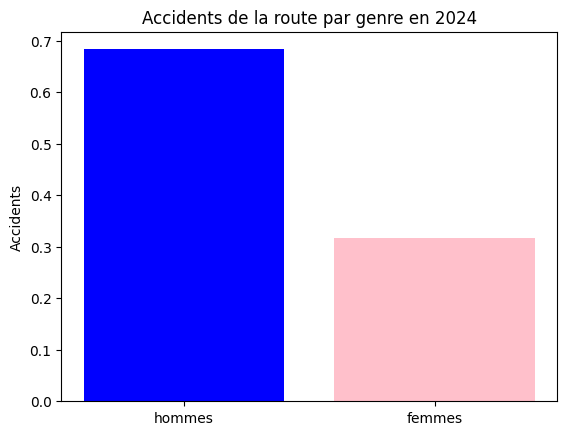

In [26]:
categories = ["hommes", "femmes"]
values = [nb_h / nb_u, nb_f / nb_u]
colors = ["blue", "pink"]

plt.ylabel("Accidents")
plt.title("Accidents de la route par genre en 2024")
plt.bar(categories, values, color=colors)
plt.show()


In [27]:
part_deces = df_u[df_u["grav"] == 4]["grav"].count() / nb_u
print(f"On a {part_deces * 100:.1f}% d'accidents de la route mortels en 2024.")

On a 40.5% d'accidents de la route mortels en 2024.


In [28]:
grav_moy = df_u["grav"].mean()
grav_moy_f = df_u_f["grav"].mean()
grav_moy_h = df_u_h["grav"].mean()

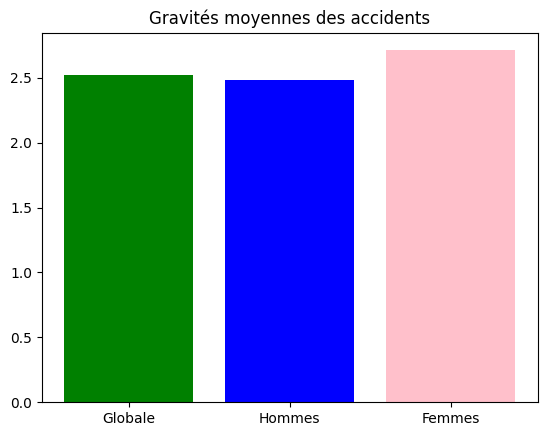

In [29]:
gravités = [grav_moy, grav_moy_h, grav_moy_f]
categories = ["Globale", "Hommes", "Femmes"]
couleurs = ["green", "blue", "pink"]

plt.bar(categories, gravités, color=couleurs)
plt.title("Gravités moyennes des accidents")
plt.show()
# Donner les écarts-types
# Sécurité moins adaptée pour les femmes ? Passagers et pas que les conducteurs.

On trouve déjà une information étonnante. Bien que les femmes soient victimes de deux fois moins d'accidents que les hommes, les accidents dont elles sont victimes sont, en moyenne, légèrement plus graves.

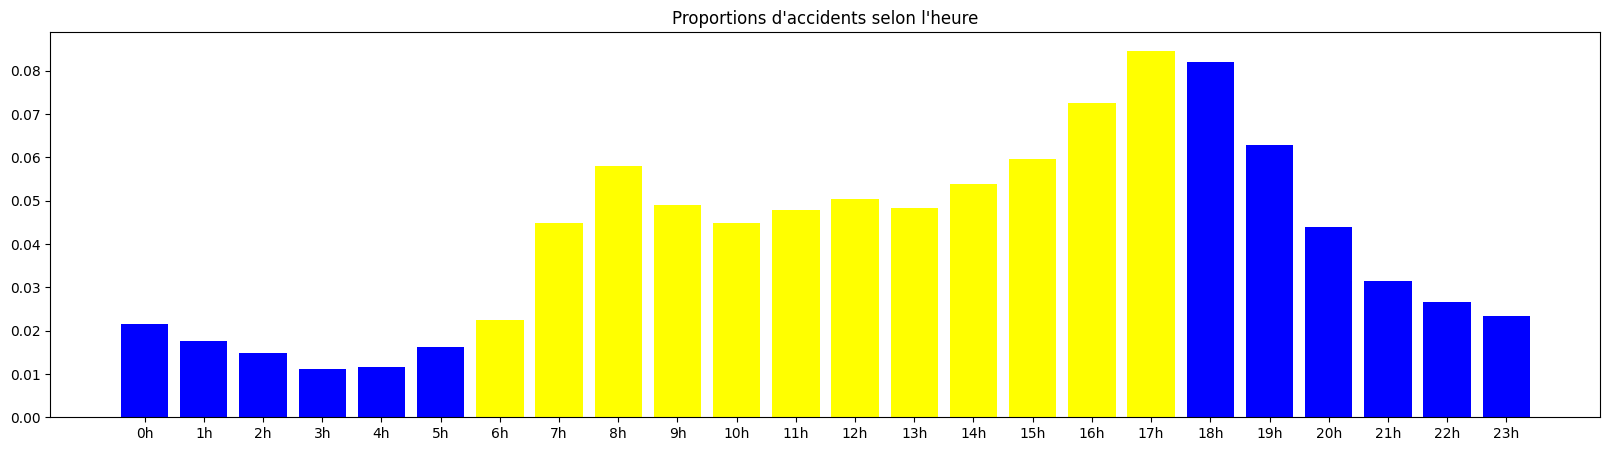

In [30]:
nb_c = df_c.count()
df_ratios_heures = df_c["hrmn"].apply(lambda s : int(s[:2])).value_counts(normalize=True)

heures = list(df_ratios_heures.sort_index())
categories = [str(k) + 'h' for k in range(24)]
couleurs = ["blue" for _ in range(6)] + ["yellow" for _ in range(12)] + ["blue" for _ in range(6)]

plt.figure(figsize=(20, 5))
plt.bar(categories, heures, color=couleurs)
plt.title("Proportions d'accidents selon l'heure")
plt.show()
# Voir s'il y a un rush hour en région ou pas

Deux phénomènes rentrent en jeu ici. D'une part, il y a très certainement beaucoup moins d'individus sur la route une fois la nuit tombée. Les pics d'accidentologie aux horaires "de pointe" (8h et 17-18h) semblent corroborer cette hypothèse. Toutefois, ceux qui roulent la nuit sont, à priori, plus en danger, et ce pour diverses raisons. On peut penser à une plus grande probabilité de conduire en étant fatigué ou ivre, ou tout simplement à cause de la visibilité réduite. 

In [31]:
nb_i = df_i.count()
df_ratios_vehicules = df_i["Catégorie véhicule"].value_counts(normalize=True)

valeurs = list(df_ratios_vehicules)
categories = list(df_ratios_vehicules.index)
couleurs = ["black", "red", "blue", "yellow", "green", "gray", "orange", "pink", "purple"]

plt.figure(figsize=(10, 5))
plt.bar(categories, valeurs, color=couleurs)
plt.title("Proportions d'accidents selon le véhicule")
plt.show()
# Normaliser par rapport au nombre de véhicules de chaque type en circulation
# Relativiser par rapport au référencement et à la gravité des accidents ?

NameError: name 'df_i' is not defined

Sans grande surprise, comme les voitures sont de loin le véhicule le plus utilisé, elles représentent une écrasante majorité des accidents.

In [ ]:
# Environ 2% des âges ne sont pas renseignés. Au vu de la petitesse de la valeur, nous avons d'éliminer ces lignes pour cette statistique.
df_ages = df_u["an_nais"].dropna().apply(lambda x : 2024 - int(x)).value_counts(normalize=True)
total = df_ages.count()
df_ages.sort_index()

plt.plot(list(df_ages.sort_index()), color='red')
plt.title("Propotions d'accidents selon l'âge des passagers")
plt.show()
#Corrélation entre gravité et âge.

On observe un pic de mortalité au début le vingtaine, et qui commence à se prononcer vers 15 et 16 ans, mais qui décroit brusquement vers la fin de la vingtaine, et suit une décroissance presque linéaire à partir de la trentaine. Ces observations paraissent raisonnables.

In [ ]:
df_cu = pd.merge(df_c, df_u, on='Num_Acc', how='inner')
df_cu.head()

In [ ]:
df_grav_by_dep = df_cu.groupby('dep')['grav'].mean()
df_grav_by_dep.sort_values().head()

In [ ]:
top_10 = df_grav_by_dep.sort_values(ascending = False)[:10]

plt.figure(figsize=(10, 5))
couleurs = ["black", "red", "blue", "yellow", "green", "gray", "orange", "pink", "purple", 'cyan']
plt.bar(top_10.index, top_10.values, color=couleurs)
plt.title("Les 10 départements avec la plus haute gravité moyenne d'accidents")
plt.show()

In [ ]:
top_10 = df_grav_by_dep.sort_values(ascending = True)[:10]

plt.figure(figsize=(10, 5))
couleurs.reverse()
plt.bar(top_10.index, top_10.values, color=couleurs)
plt.title("Les 10 départements avec la plus faible gravité moyenne d'accidents")
plt.show()
# geopandas : carte avec les départements et heatmap
# plotly pour de jolis graphes
# Scikitlearn pour le réseau de neurones

In [ ]:
df_tmp = df_cu[['dep', 'sexe']].copy()
df_tmp['sexe'] -= 1
df_f = df_tmp.groupby('dep')['sexe'].sum()
df_t = df_tmp.groupby('dep').count()
df_h = df_t - df_f
#df_h

## Inférence statistique

In [17]:
from Script import reg_log

### Régression logistique sur le sexe seul

In [18]:
reg_log(df_cond[["femme"]], df_cond["mortel"])

Optimization terminated successfully.
         Current function value: 0.124794
         Iterations 8
Odds ratios : 
const    0.032231
femme    0.509310
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 mortel   No. Observations:                90013
Model:                          Logit   Df Residuals:                    90011
Method:                           MLE   Df Model:                            1
Date:                Mon, 29 Dec 2025   Pseudo R-squ.:                0.007128
Time:                        22:43:21   Log-Likelihood:                -11233.
converged:                       True   LL-Null:                       -11314.
Covariance Type:            nonrobust   LLR p-value:                 5.943e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4348      0.022   -155.037      0.000      -3.478      -3.391
femme         -0.6747      0.057    -11.802      0.000      -0.787      -0.563
==============================================================================
"""

Ainsi, avant de contrôler le contexte, une régression logistique montre que le sexe est significativement associé à la mortalité d'un accident. Les femmes au volant ont environ 49% de chances en moins d'être impliquées dans un accident mortel que les hommes (l'odds ratio est de 0.51). Notons ici que la base de donnée ne nous permet pas de savoir si le/la conducteur.ice étudiée est responsable ou non de l'accident dont il/elle est victime.
Le modèle est statistiquement très significatif, (la p-value est très faible), mais son pouvoir explicatif reste limité (le pseudo-R² vaut 0.007). Cela suggère que d'autres facteurs ont un rôle non-négligeable dans la gravité d'un accident.

### Régression logistique multivariée

À présent, il s'agit d'étudier si, à variables constantes, le sexe a (ou non) un effet significatif sur la gravité de l’accident. Il faut donc s'interroger sur l'effet des variables ommises dans la régression précédente. En effet, on peut imaginer que des variables comme l'âge, le fait qu'il fasse jour ou nuit, ou la luminosité (très corrélée, mais la dernière variable rend compte de conditions de conduite comme le brouillard), le type de route, ou la vitesse de conduite puisse avoir un effet croisé (ou pas) avec le genre.

In [19]:
reg_log(
    df_cond[['femme', 'nuit', 'lum', 'vma', 'catr_1', 'agg', 'age_cl_[18, 30)', 'age_cl_[60, 75)', 'age_cl_[75, 125)']],
    df_cond["mortel"]
)

Optimization terminated successfully.
         Current function value: 0.113196
         Iterations 8
Odds ratios : 
const               0.182941
femme               0.536644
nuit                1.862784
lum                 1.004238
vma                 1.003499
catr_1              0.214185
agg                 0.215756
age_cl_[18, 30)     0.916788
age_cl_[60, 75)     1.907925
age_cl_[75, 125)    3.851218
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 mortel   No. Observations:                90013
Model:                          Logit   Df Residuals:                    90003
Method:                           MLE   Df Model:                            9
Date:                Mon, 29 Dec 2025   Pseudo R-squ.:                 0.09940
Time:                        22:43:24   Log-Likelihood:                -10189.
converged:                       True   LL-Null:                       -11314.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.6986      0.112    -15.193      0.000      -1.918      -1.479
femme               -0.6224      0.058    -10.743      0.000      -0.736      -0.509
nuit                 0.6221      0.056     11.029      0.000       0.512       0.733
lum                  0.0042      0.020      0.210      0.834      -0.035       0.044
vma                  0.0035      0.001      4.397      0.000       0.002       0.005
catr_1              -1.5409      0.089    -17.274      0.000      -1.716      -1.366
agg                 -1.5336      0.053    -28.817      0.000      -1.638      -1.429
age_cl_[18, 30)     -0.0869      0.052     -1.669      0.095      -0.189       0.015
age_cl_[60, 75)      0.6460      0.059     10.928      0.000       0.530       0.762
age_cl_[75, 125)     1.3484      0.068     19.712      0.000       1.214       1.482
====================================================================================
"""

Après contrôle du contexte, être un femme réduit d'environ 46% les chances de décéder des suites d'un accident. Ainsi, être une femme est un facteur protecteur majeur pour un.e conducteur.ice. Cet effet, robuste, est très proche de celui en modèle univarié, ce qui est expliqué par la faible confusion entre le sexe et les autres variables étudiées.
Ce modèle nous apprend cependant que :
- par rapport à la catégorie d'âge 30-60, avoir entre 18 (âge légal pour conduire) et 30 ans n'a pas d'effet statistiquement significatif, mais avoir entre 60 et 75 ans multiplie par deux le risque que l'accident soit mortel, et avoir plus de 75 ans le multiplie par 4 (les personnes âgées résistent moins aux accidents en général, aux accidents de la route en particulier) ;
- un accident de nuit à presque deux fois plus de chances d'être fatal pour le/la conducteur.ice ;
- la luminosité n'a pas d'effet significatif une fois les autres variables contrôlées (en effet, l'effet de la luminosité est déjà pris en compte par la variable 'nuit') ;
- la vitesse maximale autorisée a un effet modéré : chaque seuil de 10km/h passé augmente le risque de fatalité de l'accident de 3.5% ;
- un accident sur autoroute a 80% de risque en moins d'être mortel par rapport aux autres routes (ce qui est surprenant) ;
- un accident en agglomération est beaucoup moins mortel qu'un accident hors agglomération (on peut ici penser à la vitesse de conduite, probablement plus élevée hors agglomération, et à la rapidité d'arrivée des secours, plus élevée en agglomération).

On souligne également que le Pseudo-R² de McFadden, ici d'environ 0.01, indique que le modèle a une solide capacité explicative, bien que sa capacité prédictive soit limitée.

Intégration de la variable 'ceinture' :

In [20]:
reg_log(
    df_cond[['femme', 'nuit', 'lum', 'vma', 'catr_1', 'ceinture', 'agg', 'age_cl_[18, 30)', 'age_cl_[60, 75)', 'age_cl_[75, 125)']],
    df_cond["mortel"]
)

Optimization terminated successfully.
         Current function value: 0.108614
         Iterations 9
Odds ratios : 
const               0.322896
femme               0.719060
nuit                1.948243
lum                 1.012431
vma                 1.004964
catr_1              0.247473
ceinture            0.284275
agg                 0.193325
age_cl_[18, 30)     0.914705
age_cl_[60, 75)     2.073628
age_cl_[75, 125)    5.068019
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 mortel   No. Observations:                90013
Model:                          Logit   Df Residuals:                    90002
Method:                           MLE   Df Model:                           10
Date:                Mon, 29 Dec 2025   Pseudo R-squ.:                  0.1359
Time:                        22:43:32   Log-Likelihood:                -9776.7
converged:                       True   LL-Null:                       -11314.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1304      0.108    -10.480      0.000      -1.342      -0.919
femme               -0.3298      0.059     -5.556      0.000      -0.446      -0.213
nuit                 0.6669      0.057     11.635      0.000       0.555       0.779
lum                  0.0124      0.020      0.608      0.543      -0.027       0.052
vma                  0.0050      0.001      6.695      0.000       0.004       0.006
catr_1              -1.3965      0.090    -15.591      0.000      -1.572      -1.221
ceinture            -1.2578      0.045    -28.060      0.000      -1.346      -1.170
agg                 -1.6434      0.053    -31.145      0.000      -1.747      -1.540
age_cl_[18, 30)     -0.0892      0.052     -1.701      0.089      -0.192       0.014
age_cl_[60, 75)      0.7293      0.060     12.141      0.000       0.612       0.847
age_cl_[75, 125)     1.6230      0.071     22.984      0.000       1.485       1.761
====================================================================================
"""

Dans ce nouveau modèle, on remarque qu'à caractéristiques identiques, le port de la ceinture réduit le risque de décès d’environ 72 %. On remarque également que l'effet protecteur de la variable 'femme' diminue : il est maintenant lié à une diminution de 29% du risque de mortalité de l'accident. On peut estimer qu'une partie de l'effet protecteur d'être une femme passait par le port de la ceinture de sécurité, c'est-à-dire que les femmes ont davantage que les hommes tendance à porter une ceinture de sécurité ; mais que toutes choses (y compris le port de la ceinture) égales par ailleurs, être une femme reste une caractéristique protectrice.

Ce modèle réfute donc le slogan misogyne "Femme au volant, mort au tournant".

## Prédiction

Nous souhaitons, à terme, construire un réseau de neurones qui puisse, à partir des caractéristiques du/de la conducteur.ice et du trajet prévu, la gravité d'un accident. Deux possibilités s'offrent à nous :
- la classification binaire, entre les accidents mortels et les accidents non-mortels (qui regroupent les accidents dont on sort indemne, blessé.e léger.e ou blessé.e hospitalisé.e) ;
- la multiclassification, entre les quatre catégories de gravité susmentionnées.

Si les classifications binaires ont souvent de meilleures performances, la classification multiclasse propose un résultat plus riche. En outre, comme nous l'avons vu précédemment, séparer le dataset en accidents mortels et accidents non-mortels le rend particulièrement déséquilibré.

Nous proposons donc le compromis méthodologique suivant : procéder à une classification binaire, séparant les accidents mortels et graves d'un côté ('grav' ∈ {3,4}, et les accidents dont on sort indemne ou légèrement blessé ('grav' ∈ {1,2}). Le seuil de l'hospitalisation nous paraît pertinent pour distinguer deux niveaux de gravité d'accidents.

In [20]:
from Script import plot_roc_auc

### Réseau de neurones

In [21]:
from Script import rn_train, rn_evaluate, find_best_threshold

In [22]:
X_nn = df_cond[['femme', 'nuit', 'lum', 'vma', 'catr_1', 'ceinture', 'agg', 'age']].values
y_nn = df_cond['grav_binaire'].values

In [23]:
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(
    X_nn, y_nn,
    test_size=0.2,
    stratify=y_nn,
    random_state=42
)

In [24]:
model = rn_train(X_nn_train,
    X_nn_test,
    y_nn_train,
    y_nn_test)

Epoch 1/50


2025-12-29 23:19:30.754552: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1801/1801 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6855 - loss: 0.6077 - val_accuracy: 0.6920 - val_loss: 0.5446
Epoch 2/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6813 - loss: 0.5747 - val_accuracy: 0.6570 - val_loss: 0.5919
Epoch 3/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6667 - loss: 0.5677 - val_accuracy: 0.7040 - val_loss: 0.5333
Epoch 4/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6667 - loss: 0.5625 - val_accuracy: 0.6486 - val_loss: 0.5549
Epoch 5/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6693 - loss: 0.5593 - val_accuracy: 0.6157 - val_loss: 0.6128
Epoch 6/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6680 - loss: 0.5560 - val_accuracy: 0.6653 - val_loss: 0.5572
Epoch 7/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6664 - loss: 0.5549 - val_accuracy: 0.6960 - val_loss: 0.5261
Epoch 8/50
1801/1801 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6637 - loss: 0.5551 - val_accurac

In [28]:
y_prob_nn = model.predict(X_nn_test).flatten() 
y_pred_nn = (y_prob_nn >= 0.5).astype(int)

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step


Après expérimentation, on découvre qu'un seuil de 0.5 limite le recall sur la classe majoritaire, mais un seuil de 0.3 limite la précision sur la classe minoritaire. Pour déterminer le seuil optimal, on cherche le seuil qui maximise le score f1 :

In [29]:
best_threshold = find_best_threshold(
    y_nn_test = y_nn_test,
    y_nn_prob = y_prob_nn
)

In [31]:
y_nn_pred, y_nn_prob = rn_evaluate(
    model = model,
    seuil = best_threshold,
    X_test = X_nn_test
)

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step


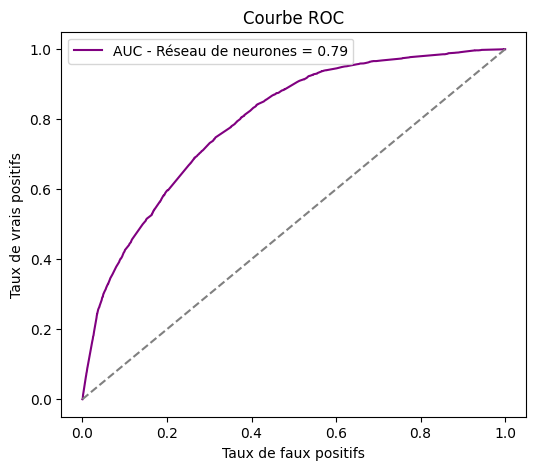

In [33]:
plot_roc_auc(
    y_test = y_nn_test,
    y_prob_rf = None,
    y_prob_xgb = None,
    y_prob_nn = y_nn_prob
)

In [34]:
print(classification_report(y_nn_test, y_nn_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     14874
           1       0.39      0.60      0.47      3129

    accuracy                           0.76     18003
   macro avg       0.64      0.70      0.66     18003
weighted avg       0.81      0.76      0.78     18003



Les performances du réseau de neurones sont intéressantes : même si une accuracy plutôt élevée peut cacher de gros déséquilibres de classe, les scores de précision et de recall, bien qu'inférieurs sur la classe minoritaire, ne sont pas aussi mauvais que ce à quoi on aurait pu s'attendre avec un dataset si déséquilibré.

### Random forest

In [35]:
X_pred = df_cond[['femme', 'nuit', 'lum', 'vma', 'catr_1', 'ceinture', 'agg', 'age']]
y_pred = df_cond['grav_binaire']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pred,
    y_pred,
    test_size=0.2,
    random_state=42,
    stratify=y_pred
)

In [37]:
from Script import random_forest

In [38]:
y_pred_rf, y_prob_rf = random_forest(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.90      0.75      0.81     14874
           1       0.33      0.60      0.43      3129

    accuracy                           0.72     18003
   macro avg       0.61      0.67      0.62     18003
weighted avg       0.80      0.72      0.75     18003



Ici aussi, la random forest prédit beaucoup de faux positifs et rate beaucoup de vrais positifs. La macro average révèle cette faiblesse de la random forest sur la classe 'grav_binaire'=1.

L'analyse de l'aire sous la courbe de la ROC curve corrobore ce résultat :

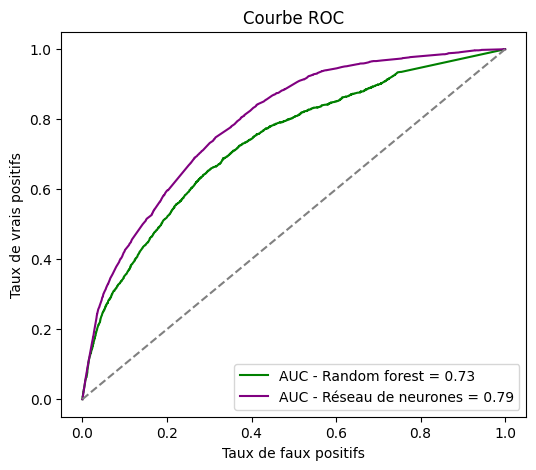

In [40]:
plot_roc_auc(
    y_test = y_test,
    y_prob_rf = y_prob_rf,
    y_prob_xgb = None,
    y_prob_nn = y_prob_nn
)

L'AUC de 0.73 indique que le modèle est meilleur que le hasard, ce qui semble indiquer que les variables utilisées sont pertinentes pour prédire le caracctère mortel d'un accident, mais qu'il manque des variables clefs. On pense notamment à l'effet de la prise d'alcool ou de stupéfiants, sur laquelle le dataset originel ne nous renseigne malheureusement pas.

### XG Boost

In [41]:
from Script import xg_boost

In [42]:
y_pred_xgb, y_prob_xgb = xg_boost(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.93      0.68      0.78     14874
           1       0.33      0.77      0.47      3129

    accuracy                           0.69     18003
   macro avg       0.63      0.72      0.63     18003
weighted avg       0.83      0.69      0.73     18003



On note que le recall pour la classe minoritaire est nettement meilleur que dans la random forest, et que la précision s'est aussi améliorée. L'amélioration du recall pour les accidents graves s'accompagne d'une diminution du recall pour les accidents légers. Il y a une amélioration de l'aire sour la courbe ROC par rapport à un forêt aléatoire classique :

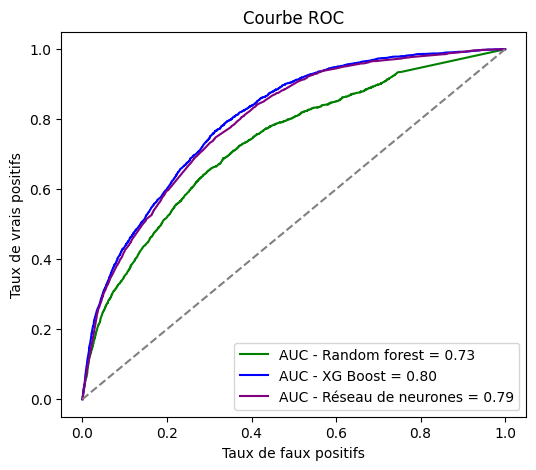

In [43]:
plot_roc_auc(
    y_test = y_test,
    y_prob_rf = y_prob_rf,
    y_prob_xgb = y_prob_xgb,
    y_prob_nn = y_prob_nn
)

###  Conclusion sur les modèles prédictifs

De manière générale, les ROC AUC montrent qu'il y a du signal, ie que les variables considérées sont intéressantes pour prédire la gravité de l'accident. Cependant, même les résultats du meilleur modèle sont symptomatiques d'un dataset très déséquilibré : même après binarisation de la gravité (censée diminuer le déséquilibre initial), le modèle est excellent sur la classe majoritaire, mais mauvais sur la classe minoritaire, tant en recall qu'en précision.

## Conclusion

Les performances des différents outils de prédiction développés sont sensiblement similaires. Ce résultat semble indiquer que les modèles sont limités par la qualité du dataset d'entraînement : 
- d'un côté, le dataset est très déséquilibré, ce qui, malgré l'utilisation de poids dans le réseau de neurones et dans le gradient boost, limite les performances du modèle sur la classe minoritaire ;
- de l'autre, il est très probable que les variables d'entrée ne soient pas suffisantes pour prédire la variable de sortie (on repense ici à la prise d'alcool ou de stupéfiants).

Néanmoins, l'objectif premier est rempli, puisque les modèles calculent un effet protecteur du genre féminin, allant ainsi à l'encontre du lieu commun "Femme au volant, mort au tournant".